In [1]:
import sys
import os

package_path = '..'
if package_path not in sys.path:
    sys.path.append(package_path)

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import os

from roi_rectangle import RoiRectangle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tables as tb
from tqdm import tqdm

In [4]:
from lmfit import Model, create_params
from lmfit.models import GaussianModel

mod = GaussianModel()

In [51]:
from scipy.special import erf


def damp_osci(x, x0, oa, rg, ro, phase, sigma, w):
    damp = oa * np.exp(-(x-x0)/rg)*np.cos((x-x0)/ro-phase)
    err_func = -0.5 * (erf(-1/np.sqrt(2)*(x-x0)/sigma - sigma/w) ) + 0.5
    return damp * err_func


def exp_decay(x, Amplitude, x0, sigma, w, oa, rg, ro, phase):
    fit1 = Amplitude/2*np.exp(-(x-x0)/w + ((sigma/w)**2)/2)*(1-erf(-1/np.sqrt(2)*(x-x0)/sigma - sigma/w))
    osc = damp_osci(x, x0, oa, rg, ro, phase, sigma, w)
    return fit1 + osc


def gaussian(x, amplitude, center, sigma, offset):
    return amplitude * np.exp(-np.power(x - center, 2.) / (2 * np.power(sigma, 2.))) + offset

mymodel = Model(gaussian)
gmodel = Model(exp_decay)

In [6]:
print(f'parameter names: {gmodel.param_names}')
print(f'independent variables: {gmodel.independent_vars}')

parameter names: ['Amplitude', 'x0', 'sigma', 'w', 'oa', 'rg', 'ro', 'phase']
independent variables: ['x']


In [64]:
params = gmodel.make_params(
    Amplitude=dict(value=0.06), 
    x0=dict(value=0.0), 
    sigma=dict(value=0.1), 
    w=dict(value=0.1), 
    oa=dict(value=0, vary=False),
    rg=dict(value=10, vary=False), 
    ro=dict(value=10, vary=False), 
    phase=dict(value=0, vary=False)
)
params

name,value,initial value,min,max,vary
Amplitude,0.06000000,0.06,-inf,inf,True
x0,0.00000000,0.0,-inf,inf,True
sigma,0.10000000,0.1,-inf,inf,True
w,0.10000000,0.1,-inf,inf,True
oa,0.00000000,0,-inf,inf,False
rg,10.0000000,10,-inf,inf,False
ro,10.0000000,10,-inf,inf,False
phase,0.00000000,0,-inf,inf,False


In [7]:
from src.analyzer.loader import NpzLoader
from src.config.config import load_config

In [8]:
config = load_config()
print("load_dir:", config.path.load_dir)
print("analysis_dir:", config.path.analysis_dir)

load_dir: /xfel/ffs/dat/ue_240607_FXS/raw_data/h5/type=raw
analysis_dir: /home/hxpp-admin/Desktop/sogang/240821_sogang/test


In [9]:
npz_dir: str = config.path.npz_dir

run_n: int = 43
scan_n: int = 1
npz_file = os.path.join(npz_dir, f"run={run_n:0>4}_scan={scan_n:0>4}.npz")
_data = NpzLoader(npz_file).data
for key, val in _data.items():
    print(key)
    print(val.shape)

pon
(60, 514, 1030)
poff
(60, 514, 1030)
delay
(60,)


In [11]:
poff_images = _data["poff"]
pon_images = _data["pon"]
delays = _data["delay"]

In [13]:
roi_rect: RoiRectangle = RoiRectangle(x1=310, y1=217, x2=552, y2=436)
roi_poffs = roi_rect.slice(poff_images)
roi_pons = roi_rect.slice(pon_images)

roi_poffs.shape

(60, 219, 242)

In [60]:
params = mymodel.make_params(
    amplitude=dict(value=100), 
    center=dict(value=100), 
    sigma=dict(value=5),
    offset=dict(value=5)
)
params

name,value,initial value,min,max,vary
amplitude,100.000000,100,-inf,inf,True
center,100.000000,100,-inf,inf,True
sigma,5.00000000,5,-inf,inf,True
offset,5.00000000,5,-inf,inf,True


In [65]:
image = roi_pons[-20]
x = np.arange(image.shape[1])
y = np.arange(image.shape[0])
sum_0 = image.sum(0)
sum_1 = image.sum(1)
result_x = gmodel.fit(sum_0, params, x=x)

In [40]:
result_x.fit_report()

"[[Model]]\n    Model(gaussian)\n[[Fit Statistics]]\n    # fitting method   = leastsq\n    # function evals   = 37\n    # data points      = 242\n    # variables        = 3\n    chi-square         = 25423.1725\n    reduced chi-square = 106.373107\n    Akaike info crit   = 1132.38382\n    Bayesian info crit = 1142.85064\n    R-squared          = 0.07203424\n[[Variables]]\n    amplitude:  19475.3544 +/- 1951.61205 (10.02%) (init = 100)\n    center:     122.952084 +/- 7.32174731 (5.95%) (init = 100)\n    sigma:      173.095265 +/- 19.9717416 (11.54%) (init = 5)\n    fwhm:       407.608191 +/- 47.0298564 (11.54%) == '2.3548200*sigma'\n    height:     44.8859344 +/- 1.02835663 (2.29%) == '0.3989423*amplitude/max(1e-15, sigma)'\n[[Correlations]] (unreported correlations are < 0.100)\n    C(amplitude, sigma) = +0.9873"

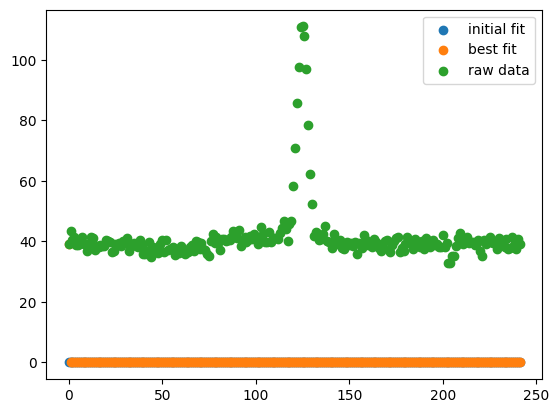

In [66]:
plt.scatter(x, result_x.init_fit, label='initial fit')
plt.scatter(x, result_x.best_fit, label='best fit')
plt.scatter(x, sum_0, label='raw data')
plt.legend()

In [55]:
x0s = []
y0s = []
for image in roi_pons:
    x = np.arange(image.shape[1])
    y = np.arange(image.shape[0])
    sum_0 = image.sum(0)
    sum_1 = image.sum(1)
    result_x = mymodel.fit(sum_0, params, x=x)
    result_y = mymodel.fit(sum_1, params, x=y)

    x0 = result_x.params['center'].value
    x0s.append(x0)
    y0 = result_y.params['center'].value
    y0s.append(y0)

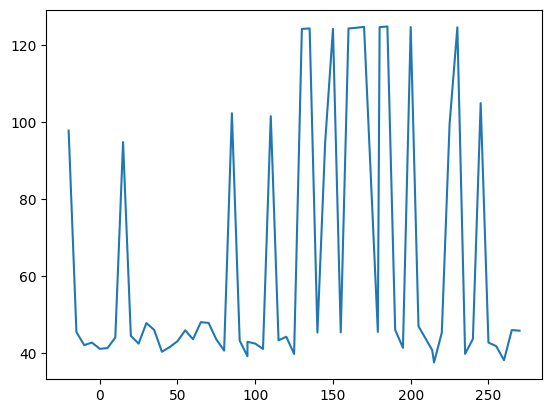

In [56]:
plt.plot(delays, x0s)

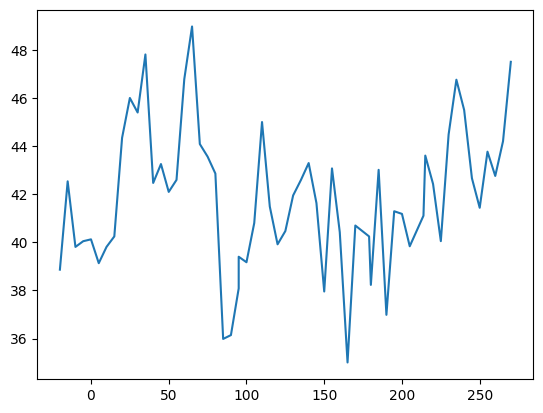

In [57]:
plt.plot(delays, y0s)